# Optimizer tweaks

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from exp.nb_08 import *

## Imagenette data

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [6]:
nfs = [32, 64, 128, 256]

In [7]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [8]:
learn, run = get_learn_run(nfs, data, .4, conv_layer, cbs=cbfs)

In [9]:
run.fit(1, learn)

train: [1.6798333708992554, tensor(0.4223, device='cuda:0')]
valid: [1.6907509765625, tensor(0.4640, device='cuda:0')]


## Refining the optimizer

In [10]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for _ in self.param_groups]
        self.steppers = listify(steppers)
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
               for p in pg if p.grad is not None]
    def zero_grad(self):
        for p, _ in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [11]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [12]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [13]:
class Recorder(Callback):
    # It records the learning rate and the losses at
    # each iteration.
    
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])
    
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, listify(sched_funcs)
        
    def begin_batch(self):
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs) == 1: fs = len(self.opt.param_groups) * fs
        pos = self.n_epochs / self.epochs
        for f, h in zip(fs, self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr)**pos
        for pg in self.opt.hypers: pg['lr'] = lr
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > 10 * self.best_loss:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss
    
        

In [14]:
sched = combine_scheds([.3, .7], [sched_cos(.3, .6), sched_cos(.6, .2)])

In [15]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback,
        Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [16]:
learn, run = get_learn_run(nfs, data, .4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [17]:
%time run.fit(1, learn)

train: [1.7246729947068404, tensor(0.4125, device='cuda:0')]
valid: [1.2853946533203124, tensor(0.5820, device='cuda:0')]
CPU times: user 5.26 s, sys: 2.12 s, total: 7.37 s
Wall time: 7.99 s


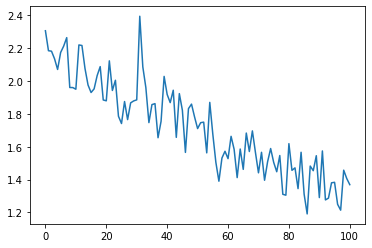

In [18]:
run.recorder.plot_loss()

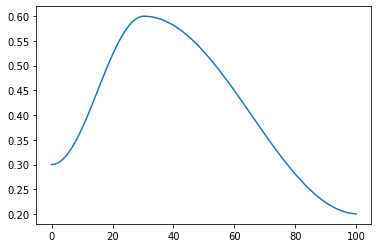

In [19]:
run.recorder.plot_lr()

## Weight decay

In [20]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p

weight_decay._defaults = dict(wd=0.)

In [21]:
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

In [22]:
def maybe_update(os, dest, f):
    for o in os:
        for k, v in f(o).items():
            if k not in dest: dest[k] = v
                
def get_defaults(d): return getattr(d, '_defaults', {})

In [23]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
               for p in pg if p.grad is not None]
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    def step(self):
        for p, hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [24]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [25]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [26]:
model = learn.model

In [27]:
opt = sgd_opt(model.parameters(), lr=.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [28]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)

In [29]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback]

In [30]:
learn, run = get_learn_run(nfs, data, .3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=.01))

In [31]:
run.fit(1, learn)

train: [1.7130342237668683, tensor(0.4111, device='cuda:0')]
valid: [1.832463134765625, tensor(0.3740, device='cuda:0')]


## With momentum

In [41]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p, hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [42]:
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

In [43]:
class AverageGrad(Stat):
    _defaults = dict(mom=.9)
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [44]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [45]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay],
                      stats=AverageGrad(), wd=0.01)

In [46]:
learn, run = get_learn_run(nfs, data, .3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [47]:
run.fit(1, learn)

train: [1.9416807235923685, tensor(0.3535, device='cuda:0')]
valid: [2.44590771484375, tensor(0.2080, device='cuda:0')]
